# Sentiment analysis 

This is a jupyter notebook for a project to detect the sentiments of movie reviews.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses

2024-10-11 20:55:47.394114: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('hello world!')

hello world!


In [3]:
print(tf.__version__)

2.16.2


## Import dataset
We will use a dataset of movie reviews from IMDB, provided by [stanford university](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz).
Then, we use the get_file function from keras (included in tensorflow) to download the dataset.

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='data',
                                  cache_subdir='')

We define variables for the directories where the data is stored. Directories contain a text file for each review, positive ones are in the 
_pos_ directory and negative are in the _neg_ directory.

In [5]:
dataset_dir=os.path.join(os.path.dirname(dataset), 'aclImdb')
train=os.path.join(dataset_dir,'train')
test=os.path.join(dataset_dir,'test')

We will remove the _unsup_ directory in the train data, as we will use supervised learning for this project (and this will simplify data
loading in the following step)

In [6]:
remove=os.path.join(train,'unsup')
shutil.rmtree(remove)

To load the data, we will use the _text_dataset_from_directory_ function in keras to load the data to memory. This function expect the following
structure 
```text
dir/
    class_1/
        point_1.txt
        point_2.txt
    class_2/
        point_1.txt
        point_2.txt
```
which is conveniently followed by the dataset. In this case, neg will have the label 0 and pos the label 1. 
The dataset will be loaded in batches of 32 points (so it will yield groups of 32 points on each iteration) and the value 40 is used
as a random seed for shuffling. It also will reserve 20% of the dataset for validation (used to tune hyperparameters)

In [7]:
batch_size = 32
seed = 40

raw_training_ds = tf.keras.utils.text_dataset_from_directory(
    train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
print("Label 0 corresponds to", raw_training_ds.class_names[0])
print("Label 1 corresponds to", raw_training_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [9]:
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [10]:
raw_testing_ds = tf.keras.utils.text_dataset_from_directory(
    test,
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


We define the function _custom_standardization_ to sanitize the text in each review, which 
- Converts each character to lower case
- Removes HTLM line breaks
- Removes punctuation 

In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [12]:
max_tokens = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization, #A function that is called for each input to standarize it
    max_tokens=max_tokens, #maximum size of the vocabulary (it will have the "top max_tokens" words)
    output_mode='int', #return an int for each word
    output_sequence_length=sequence_length # maximum length of a review 
    )

In [13]:
# Make a text-only dataset (without labels), then call adapt to build the vocabulary
train_text = raw_training_ds.map(lambda x, y: x)
#build a vocabulary of all tokens in the dataset
vectorize_layer.adapt(train_text) 

2024-10-11 20:57:56.380078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
def vectorize_text(text, label):
  # print('previous expansion', vectorize_layer(text))
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

Then, we run the following code to see the input that the neural network will have.

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_training_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_training_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'I still liked it though. Warren Beatty is only fair as the comic book hero. What saves this movie is the set, the incredible cast and it offshoots a mediocre script. I really expected something more substantial in the terms of action, or plot but I got very little. The main reason to watch this movie is to watch some of the biggest stars in Hollywood at the time in such an unusual film. <br /><br />The one person who did a terrible job and did not even belong in this film was Madonna. She did not belong in this movie and her acting job was pretty bad. The movie at some points just stood still. You expected something more and you got nothing. Al Pacino plays a really bad dude and he does pretty good. He and Beatty do make an excellent good guy and bad guy. <br /><br />It is also interesting to see Dustin Hoffman, and Warren Beatty in a film other than Isthar. I did not see Ishtar but I heard bad things. The thing about this movie is it is good, but it could have been 

Import embeddings from GloVe, with the 100d version. We will download them from the Stanford site, to then load them into a dictionary and create a matrix that will be used in the embedding layer to map each int from the vectorized text (which represents a word) into a vector of 100 dimensions. 

In [16]:
def load_embeddings(path):
    ans = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            ans[word] = vector
    return ans 

In [17]:
url = "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
embeddings_file = tf.keras.utils.get_file("glove.6B", url,
                                  extract=True, cache_dir='data',
                                  archive_format='zip',cache_subdir='glove.6B')

In [18]:
path = 'data/glove.6B/glove.6B.100d.txt'
embeddings = load_embeddings(path) # load embeddings into the embedding dict
print(embeddings['hello']) # see the embedding of the token 'hello'

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.27326    0.15636   -0.20334
  0.53586    0.59784   

Create a matrix to use in the embedding layer with the current vocabulary, where the i-th vector of the matrix is the embedding for the i-th word

In [19]:
vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
num_tokens = len(vocabulary) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits+=1
    else:
        misses+=1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9888 words (112 misses)


In [20]:
# Vectorize each review in the datasets 
train_ds = raw_training_ds.map(vectorize_text)
val_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_testing_ds.map(vectorize_text)

In [21]:
# Optimize data fetching with the prefetch option
autotune = tf.data.AUTOTUNE #dynamically change buffer size
train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

# The neural network

In this section we define each model that will be tested using the keras Sequential function, which places the layers in the defined order. The Dropout layer randomly sets input units to 0 at each step during training to prevent overfitting. 

In [22]:

# Bidirectional LSTM model using Stanford embeddings
bidirectional_model = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim, trainable=False,weights=[embedding_matrix]), 
  layers.Dropout(0.2), # prevent overfitting
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')])

# LSTM model using Stanford embeddings
LSTM_model =  tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim, trainable=False,weights=[embedding_matrix]),
  layers.Dropout(0.2), # prevent overfitting
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')])

# Model using trainable embeddings and Global Average Pooling 
average_model = tf.keras.Sequential([
  layers.Embedding(num_tokens, embedding_dim), #transform the word index into a vector of dimension embedding_dim (16)
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1,activation='sigmoid')])

# CNN model using Stanford embeddings
CNN_model = tf.keras.Sequential([
    layers.Embedding(num_tokens, embedding_dim, trainable=False,weights=[embedding_matrix]), 
    layers.Conv1D(250 , 3, padding='valid',
                 activation='relu', strides=1),
    layers.GlobalMaxPooling1D(),
    layers.Dense(250  , activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

bidirectional_model.summary()

# Note: model.summary() outputs wrong  Trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,200 (3.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,200 (3.82 MB)

Compile each model using Binary Crossentropy as the loss function and Adam as the optimizer. 

In [23]:
bidirectional_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
LSTM_model.compile(loss=losses.BinaryCrossentropy(),optimizer='adam',metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
average_model.compile(loss=losses.BinaryCrossentropy(),optimizer='adam',metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
CNN_model.compile(loss=losses.BinaryCrossentropy(),optimizer='adam',metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

# Training

We will train all the models to make graphs later about their performance and save their weights for later use. 

In [24]:
epochs = 10
history_bidirectional_model = bidirectional_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)
history_LSTM_model = LSTM_model.fit(train_ds,validation_data=val_ds,epochs=epochs)
history_average_model = average_model.fit(train_ds,validation_data=val_ds,epochs=epochs)
history_CNN_model = CNN_model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 136ms/step - binary_accuracy: 0.5953 - loss: 0.6617 - val_binary_accuracy: 0.7498 - val_loss: 0.5267
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - binary_accuracy: 0.7868 - loss: 0.4645 - val_binary_accuracy: 0.8352 - val_loss: 0.3821
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - binary_accuracy: 0.8233 - loss: 0.4000 - val_binary_accuracy: 0.8412 - val_loss: 0.3629
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - binary_accuracy: 0.8340 - loss: 0.3757 - val_binary_accuracy: 0.8498 - val_loss: 0.3533
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - binary_accuracy: 0.8421 - loss: 0.3614 - val_binary_accuracy: 0.8504 - val_loss: 0.3474
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - binary_accuracy: 0.8485 - loss: 0.3477 - val_binary_accuracy: 0.8488 - val_loss: 0.3434
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - binary_accuracy: 0.8545 - loss: 0.3367 - val_binary_accuracy: 0.8544 - va

# Test model

Test the trained models using the test dataset to get an accuracy measurement with unseen data. 

In [25]:
loss_bidirectional_model, accuracy_bidirectional_model = bidirectional_model.evaluate(test_ds)
loss_LSTM_model, accuracy_LSTM_model = LSTM_model.evaluate(test_ds)
loss_average_model, accuracy_average_model = average_model.evaluate(test_ds)
loss_CNN_model, accuracy_CNN_model = CNN_model.evaluate(test_ds)

print("Loss: ", loss_bidirectional_model)
print("Accuracy: ", accuracy_bidirectional_model)

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - binary_accuracy: 0.8526 - loss: 0.3406
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - binary_accuracy: 0.8568 - loss: 0.3275
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8639 - loss: 0.3300
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - binary_accuracy: 0.8462 - loss: 0.5687
Loss:  0.34592321515083313
Accuracy:  0.849560022354126


# Save the model to a keras file

We save the models to a keras file to avoid training them again to use them later. 

In [26]:
bidirectional_model.save('models/bidirectional_model.keras')
LSTM_model.save('models/LSTM_model.keras')
average_model.save('models/average_model.keras')
CNN_model.save('models/CNN_model.keras')

# Load saved model

In [27]:
new_bidirectional_model = tf.keras.models.load_model('models/bidirectional_model.keras')
new_LSTM_model = tf.keras.models.load_model('models/LSTM_model.keras')
new_average_model = tf.keras.models.load_model('models/average_model.keras')
new_CNN_model = tf.keras.models.load_model('models/CNN_model.keras')

## Get history information

We get the history from the training of each model, which will be used later for the graphs. 

In [28]:
history_dict_bidirectional_model = history_bidirectional_model.history

acc_bidirectional_model = history_dict_bidirectional_model['binary_accuracy']
val_acc_bidirectional_model = history_dict_bidirectional_model['val_binary_accuracy']
loss_bidirectional_model = history_dict_bidirectional_model['loss']
val_loss_bidirectional_model = history_dict_bidirectional_model['val_loss']

history_dict_LSTM_model = history_LSTM_model.history
acc_LSTM_model = history_dict_LSTM_model['binary_accuracy']
val_acc_LSTM_model = history_dict_LSTM_model['val_binary_accuracy']
loss_LSTM_model = history_dict_LSTM_model['loss']
val_loss_LSTM_model = history_dict_LSTM_model['val_loss']

history_dict_average_model = history_average_model.history
acc_average_model = history_dict_average_model['binary_accuracy']
val_acc_average_model = history_dict_average_model['val_binary_accuracy']
loss_average_model = history_dict_average_model['loss']
val_loss_average_model = history_dict_average_model['val_loss']

history_dict_CNN_model = history_CNN_model.history
acc_CNN_model = history_dict_CNN_model['binary_accuracy']
val_acc_CNN_model = history_dict_CNN_model['val_binary_accuracy']
loss_CNN_model = history_dict_CNN_model['loss']
val_loss_CNN_model = history_dict_CNN_model['val_loss']

# Plotting
## Training and validation loss and accuracy 
### Bidirectional model

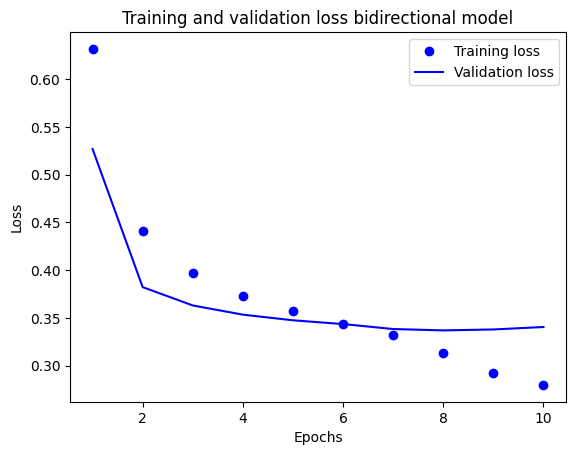

In [29]:

epochs = range(1, len(acc_bidirectional_model) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_bidirectional_model, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss_bidirectional_model, 'b', label='Validation loss')
plt.title('Training and validation loss bidirectional model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

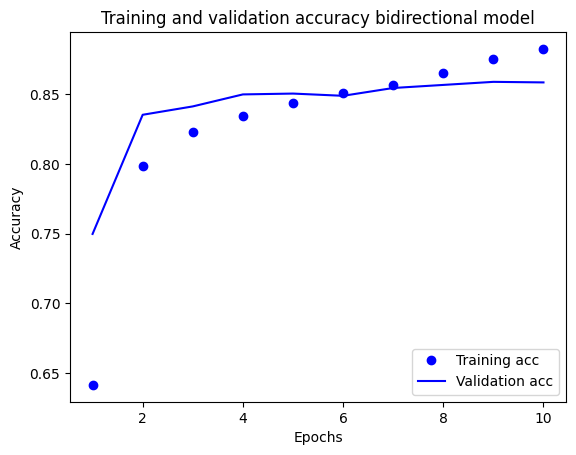

In [30]:
plt.plot(epochs, acc_bidirectional_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_bidirectional_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy bidirectional model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### LSTM model

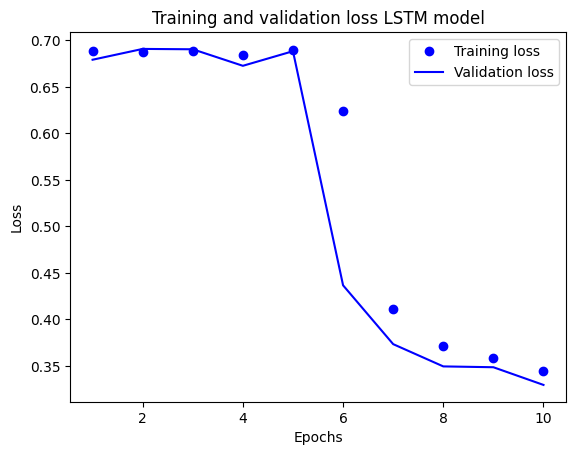

In [31]:
epochs = range(1, len(acc_LSTM_model) + 1)
plt.plot(epochs, loss_LSTM_model, 'bo', label='Training loss')
plt.plot(epochs, val_loss_LSTM_model, 'b', label='Validation loss')
plt.title('Training and validation loss LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

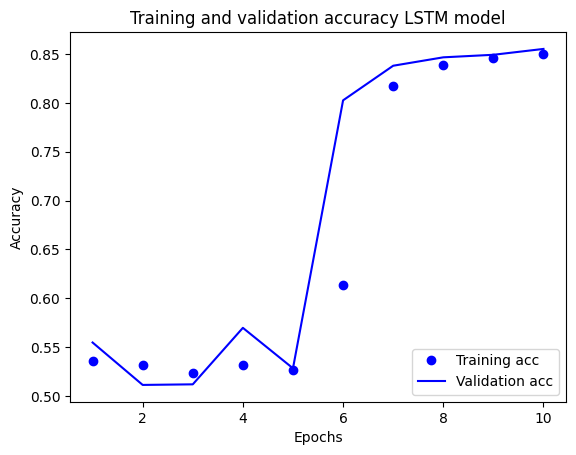

In [32]:
plt.plot(epochs, acc_LSTM_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_LSTM_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Average model

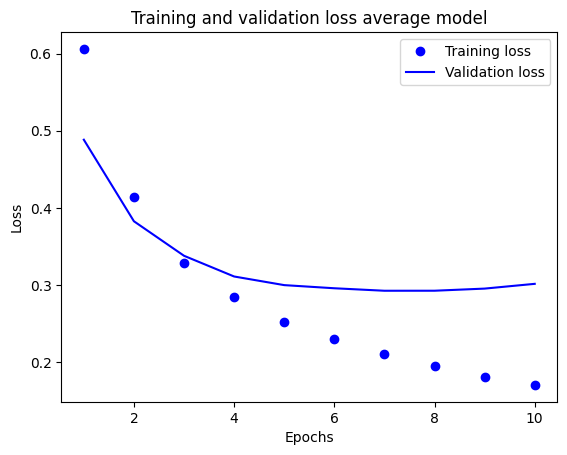

In [33]:
epochs = range(1, len(acc_average_model) + 1)
plt.plot(epochs, loss_average_model, 'bo', label='Training loss')
plt.plot(epochs, val_loss_average_model, 'b', label='Validation loss')
plt.title('Training and validation loss average model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

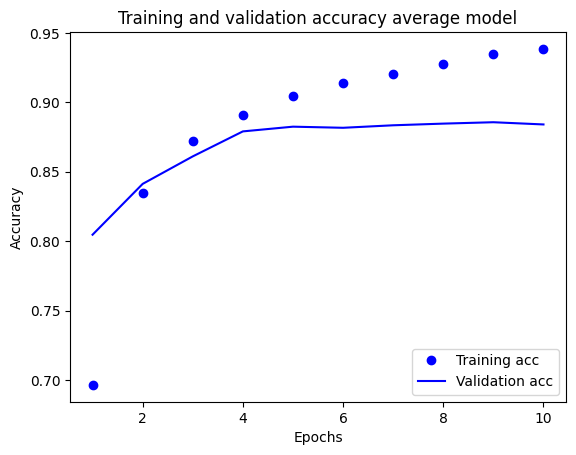

In [34]:
plt.plot(epochs, acc_average_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_average_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy average model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### CNN model

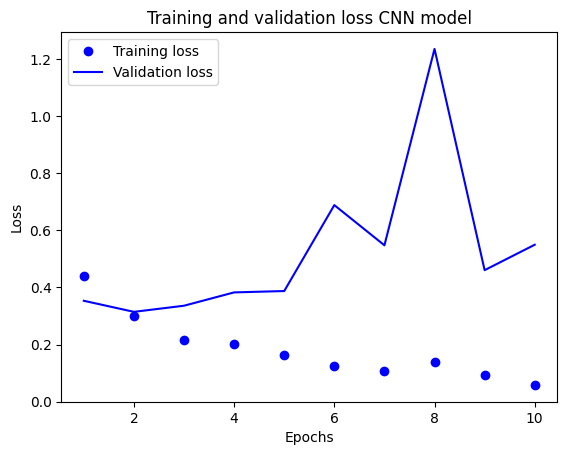

In [35]:
epochs = range(1, len(acc_CNN_model) + 1)
plt.plot(epochs, loss_CNN_model, 'bo', label='Training loss')
plt.plot(epochs, val_loss_CNN_model, 'b', label='Validation loss')
plt.title('Training and validation loss CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

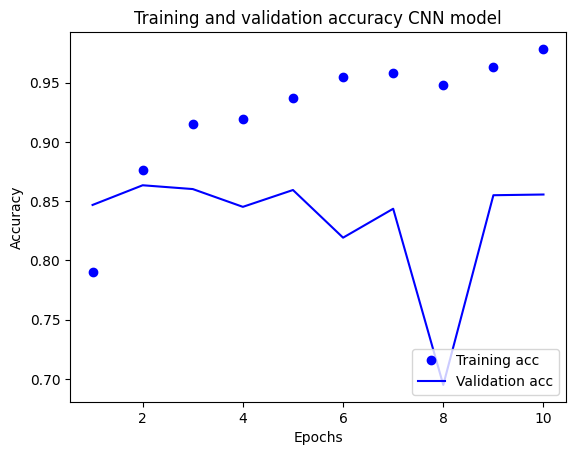

In [36]:
plt.plot(epochs, acc_CNN_model, 'bo', label='Training acc')
plt.plot(epochs, val_acc_CNN_model, 'b', label='Validation acc')
plt.title('Training and validation accuracy CNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


## All models training and validation loss

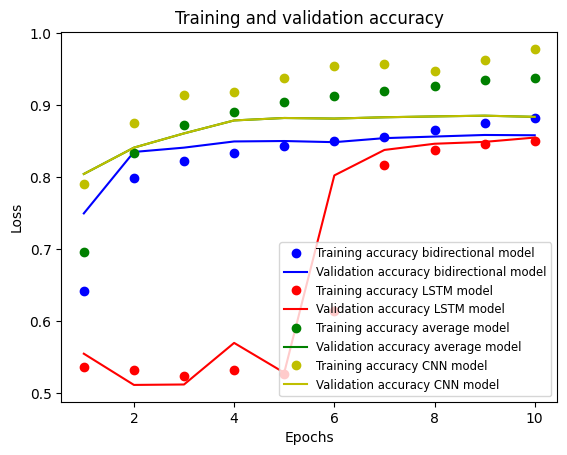

In [37]:
# "bo" is for "blue dot"
plt.plot(epochs, acc_bidirectional_model, 'bo', label='Training accuracy bidirectional model')
# b is for "solid blue line"
plt.plot(epochs, val_acc_bidirectional_model, 'b', label='Validation accuracy bidirectional model')

plt.plot(epochs, acc_LSTM_model, 'ro', label='Training accuracy LSTM model')
plt.plot(epochs, val_acc_LSTM_model, 'r', label='Validation accuracy LSTM model')

plt.plot(epochs, acc_average_model, 'go', label='Training accuracy average model')
plt.plot(epochs, val_acc_average_model, 'g', label='Validation accuracy average model')

plt.plot(epochs, acc_CNN_model, 'yo', label='Training accuracy CNN model')
plt.plot(epochs, val_acc_average_model, 'y', label='Validation accuracy CNN model')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize='small')

plt.show()

# Try the model with new input

This section contains examples of ways to use the model for new input, with constant examples or a more elaborate example using reviews from the film _Joker: Folie à Deux_ from the site [Rotten Tomatoes](https://www.rottentomatoes.com/m/joker_folie_a_deux). For this last example, the reviews can be downloaded using the _get\_reivews.py_ file.

In [38]:
example, _ = vectorize_text('such a horrible movie, would not recommend',0)
new_bidirectional_model.predict(example) #show the plain output for the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


array([[0.07897136]], dtype=float32)

Create a new model that gives the label 'pos' or 'neg' that can be used on plain text.

In [57]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  bidirectional_model,
  tf.keras.layers.Lambda(lambda x: tf.where(x >= 0.5, 'pos', 'neg'))
])

In [58]:
# Try the model with some constant inputs.
examples = tf.constant([
  "The movie was great!",
  "The movie was the best.",
  "Such a horrible movie, would not recommend",
  "It was average, not that good but not bad either",
  "I really disliked the musical part of the movie, but the overall storyline was acceptable",
  "The plot was awful, please don't waste your time here",
  "Too much like a musical. Not enough action, majority of the time was in court and didn’t really anywhere with this story. I felt like they really dropped the ball on this one. Sounds rough but save your money, you didn’t miss much",
  "Majestically confusing, impossible to follow.",
  "Breathtakingly mediocre, as if it’s striving for nothing special",
  "Spectacularly forgettable.",
  "Delightfully miserable, in a way that’s hard to describe."
])
export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


array([[b'pos'],
       [b'pos'],
       [b'neg'],
       [b'neg'],
       [b'neg'],
       [b'neg'],
       [b'neg'],
       [b'neg'],
       [b'neg'],
       [b'neg'],
       [b'neg']], dtype=object)

Finally, we test the model with the reviews from the film, to later make a pie chart of the overall performance for the movie. 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


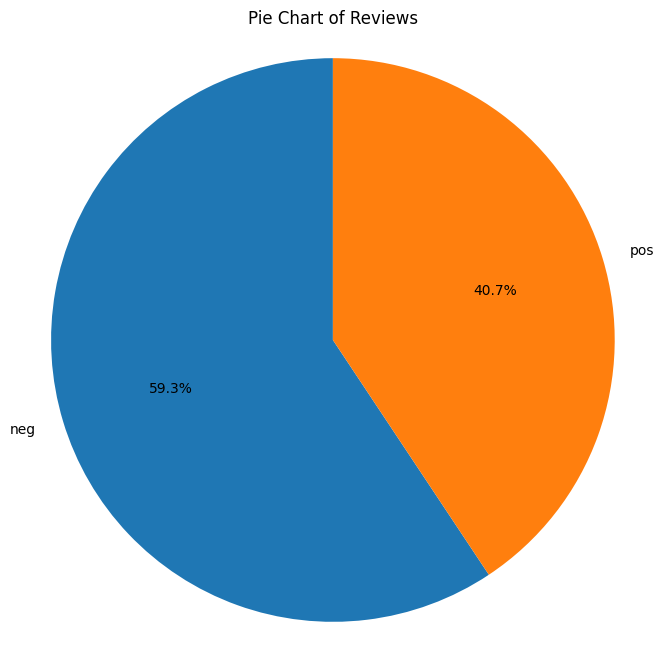

In [41]:
tomato_paths = 'data/reviews.csv'
tomato_test = pd.read_csv(tomato_paths)
tomato_test.head()
text_column = tomato_test['review']

text_column.values
text_ds = tf.constant(text_column.values)
ans = export_model.predict(text_ds)
ans = ans.flatten().astype(str)
labels, counts = np.unique(ans, return_counts=True)
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()